In [1]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/celebs_20"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

import neptune.new as neptune

from config import NEPTUNE_TOKEN

import time 
import copy
import random
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3
from MBNV3CBAM import MobileNetV3CBAM

from dataloader import mixedSets
from functions import train, evaluate, confusion, unzip_files, unzip

In [2]:
#Initialising GereralTorch class

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 5,
    'batch_size': 32,
    'image_size': 112,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_test_split': [0.8, 0.1, 0.1],
    'device': 'mps',
    'model_name': 'MobileNet3 with CBAM inserted instead of SE starting from a fresh model with no preloaded weights.',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'Celebrities 20',
    'best_model_path': 'output/MN3LCB_celebs20.pt',
    'loaded_model_path': False,
    'save_at_end': True,
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3CBAM(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict, strict= True) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3CBAM(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

Output Size: 20


In [3]:
#Setting the experiment with the API key stored in config.py
run = neptune.init(project="leothesouthafrican/Thesis", api_token=NEPTUNE_TOKEN,
                                    source_files=["*.ipynb"])

#Logging the hyperparameters to the run on neptune
run["hyper-parameters"] = hyper_params
run["train/images"].track_files(data_path)

#Loading the model to neptune
neptune_model_version = neptune.init_model_version(
    model="THES-MBNCBAM",
    project="leothesouthafrican/Thesis",
    api_token=NEPTUNE_TOKEN, # your credentials
)

/var/folders/ml/c8rn7lrd26ldmv5b648kshhh0000gn/T/ipykernel_19639/3431031350.py:2: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  run = neptune.init(project="leothesouthafrican/Thesis", api_token=NEPTUNE_TOKEN,


https://app.neptune.ai/leothesouthafrican/Thesis/e/THES-17


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/var/folders/ml/c8rn7lrd26ldmv5b648kshhh0000gn/T/ipykernel_19639/3431031350.py:6: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` or `repr(object)` instead. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  run["hyper-parameters"] = hyper_params


https://app.neptune.ai/leothesouthafrican/Thesis/m/THES-MBNCBAM/v/THES-MBNCBAM-5
Remember to stop your model_version once you’ve finished logging your metadata (https://docs.neptune.ai/api/model_version#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.RandomCrop(hyper_params['image_size'], padding=2)], p=0.4),
                transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,1.2)),
                transforms.RandomRotation(35),
                transforms.RandomHorizontalFlip(0.15),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomErasing(0.1),
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            ])

#Logging the transforms to neptune
run["train/transforms"] = train_transform
run["test/transforms"] = test_transform

In [5]:
# Creating the dataset
train_dataset = mixedSets(data_path, train_transform, hyper_params['train_val_test_split']).get_train_dataset()
val_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_val_dataset()
test_dataset = mixedSets(data_path, test_transform, hyper_params['train_val_test_split']).get_test_dataset()

# Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=1)

#Logging the dataset to neptune
run["train/dataset"] = train_dataset
run["val/dataset"] = val_dataset
run["test/dataset"] = test_dataset

Train dataset size: 2642, with 20 classes
Val dataset size: 331, with 20 classes
Test dataset size: 331, with 20 classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


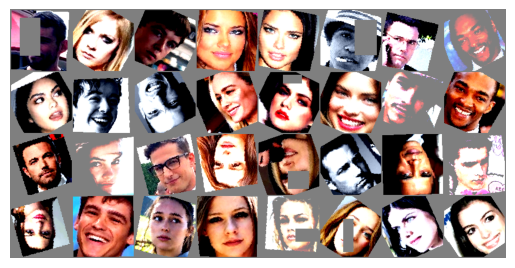

In [6]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

#save image to output folder
torchvision.utils.save_image(torchvision.utils.make_grid(images), 'output/train_images.png')

#Logging the images to neptune
#run["train/images"].upload('output/train_images.png')

In [7]:
train(model, criterion, optimizer, hyper_params, train_loader, val_loader, run)

Begin training...


100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


Best model saved at epoch 2 with accuracy 0.0725 and loss 3.1974.
	Train Loss: 3.279 | Train Acc: 5.555555820465088%
Epoch: 02 | Epoch Time: 0m 30s
	 Val. Loss: 3.197 |  Val. Acc: 7.250755287009064%


100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


	Train Loss: 2.833 | Train Acc: 16.666667938232422%
Epoch: 03 | Epoch Time: 0m 27s
	 Val. Loss: 3.051 |  Val. Acc: 6.948640483383686%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 4 with accuracy 0.1118 and loss 2.8696.
	Train Loss: 2.932 | Train Acc: 5.555555820465088%
Epoch: 04 | Epoch Time: 0m 28s
	 Val. Loss: 2.870 |  Val. Acc: 11.178247734138973%


100%|██████████| 11/11 [00:06<00:00,  1.79it/s]


Best model saved at epoch 5 with accuracy 0.1511 and loss 2.7451.
	Train Loss: 2.890 | Train Acc: 11.111111640930176%
Epoch: 05 | Epoch Time: 0m 28s
	 Val. Loss: 2.745 |  Val. Acc: 15.105740181268882%


100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

	Train Loss: 3.173 | Train Acc: 0.0%
Epoch: 06 | Epoch Time: 0m 28s
	 Val. Loss: 2.798 |  Val. Acc: 10.876132930513595%


In [8]:
model.load_state_dict(torch.load(hyper_params['best_model_path'])) #Loading the state dict into the model
test_loss, test_acc = evaluate(model, test_loader, criterion, device, run) 
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 11/11 [00:06<00:00,  1.80it/s]

Test Loss: 2.747 | Test Acc: 15.88%


In [9]:
neptune_model_version["model"].upload(hyper_params['best_model_path'])
neptune_model_version["validation/acc"] = test_acc
neptune_model_version["validation/loss"] = test_loss
neptune_model_version["validation/dataset"] = test_dataset

In [10]:
#download the model
neptune_model_version["model"].download('output/neptune_model.pth')

Run THES-17 received stop signal. Exiting
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/leothesouthafrican/Thesis/e/THES-17


: 